## Importing the Libraries

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorflow as tf

## Loading and Preprocessing the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
ZERO = '/content/drive/MyDrive/Colab Notebooks/NeuralNetworksFromScratch/Image files/trainingSet/trainingSet/0'
ONE =  '/content/drive/MyDrive/Colab Notebooks/NeuralNetworksFromScratch/Image files/trainingSet/trainingSet/1'
TWO = '/content/drive/MyDrive/Colab Notebooks/NeuralNetworksFromScratch/Image files/trainingSet/trainingSet/2'
THREE = '/content/drive/MyDrive/Colab Notebooks/NeuralNetworksFromScratch/Image files/trainingSet/trainingSet/3'
FOUR = '/content/drive/MyDrive/Colab Notebooks/NeuralNetworksFromScratch/Image files/trainingSet/trainingSet/4'
FIVE = '/content/drive/MyDrive/Colab Notebooks/NeuralNetworksFromScratch/Image files/trainingSet/trainingSet/5'
SIX = '/content/drive/MyDrive/Colab Notebooks/NeuralNetworksFromScratch/Image files/trainingSet/trainingSet/6'
SEVEN = '/content/drive/MyDrive/Colab Notebooks/NeuralNetworksFromScratch/Image files/trainingSet/trainingSet/7'
EIGHT = '/content/drive/MyDrive/Colab Notebooks/NeuralNetworksFromScratch/Image files/trainingSet/trainingSet/8'
NINE = '/content/drive/MyDrive/Colab Notebooks/NeuralNetworksFromScratch/Image files/trainingSet/trainingSet/9'

In [5]:
training_data = []
validation_data = []
testing_data = []
number_of_zeros = 0
paths_dict = {ZERO: 0, ONE: 1, TWO: 2, THREE: 3, FOUR: 4, FIVE: 5, SIX: 6, SEVEN: 7, EIGHT: 8, NINE: 9}
paths_list = [ZERO, ONE, TWO, THREE, FOUR, FIVE, SIX, SEVEN, EIGHT, NINE]
dataset_loaded = False

In [6]:
if dataset_loaded is False:
  for folder in paths_list:
    image_count = 0
    for image_path in tqdm(os.listdir(folder)):
      if image_count < 1000:
        if "jpg" in image_path:
          path = os.path.join(folder, image_path)
          image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          if image is not None:
            flattened_input = image.reshape(-1)
            flattened_input = flattened_input/255
            training_data.append([flattened_input, np.eye(10)[paths_dict[folder]]])
            image_count += 1
      elif (image_count >= 1000) and (image_count < 1200):
        if "jpg" in image_path:
          path = os.path.join(folder, image_path)
          image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          if image is not None:
            flattened_input = image.reshape(-1)
            flattened_input = flattened_input/255
            validation_data.append([flattened_input, np.eye(10)[paths_dict[folder]]])
            image_count += 1
      elif (image_count >= 1200) and (image_count < 1600):
        if "jpg" in image_path:
          path = os.path.join(folder, image_path)
          image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          if image is not None:
            flattened_input = image.reshape(-1)
            flattened_input = flattened_input/255
            testing_data.append([flattened_input, np.eye(10)[paths_dict[folder]]])
            image_count += 1
      else:
        break
dataset_loaded = True

 38%|███▊      | 1600/4188 [01:25<02:18, 18.75it/s] 


In [7]:
np.random.shuffle(training_data)
np.random.shuffle(validation_data)
np.random.shuffle(testing_data)

In [8]:
print(len(training_data))
print(len(validation_data))
print(len(testing_data))

10000
2000
4000


### Defining a function to divide the dataset into batches

In [9]:
def mini_batch(dataset, batch_size):
  batched_data = []
  dataset_size = int(len(dataset)/batch_size)*batch_size
  dataset = dataset[:dataset_size]
  for i in range(0, dataset_size, batch_size):
    batched_data.append(dataset[i:i+batch_size])
  return batched_data

### Making mini-batches out of the train set and separating the features and labels

In [10]:
batched_training_data = mini_batch(training_data, 64)

In [12]:
batched_features = []
batched_labels = []

for i in range(len(batched_training_data)):
  features_list = []
  labels_list = []
  for j in range(64):
    features_list.append(batched_training_data[i][j][0])
    labels_list.append(batched_training_data[i][j][1])
  batched_features.append(np.array(features_list))
  batched_labels.append(np.array(labels_list))

batched_features = np.array(batched_features)
batched_labels = np.array(batched_labels)

### Making mini-batches out of the validation set and separating the features and labels

In [16]:
batched_validation_data = mini_batch(validation_data, 64)

31

In [20]:
validation_features = []
validation_labels = []

for i in range(len(batched_validation_data)):
  features_list = []
  labels_list = []
  for j in range(64):
    features_list.append(batched_validation_data[i][j][0])
    labels_list.append(batched_validation_data[i][j][1])
  validation_features.append(np.array(features_list))
  validation_labels.append(np.array(labels_list))

batched_validation_features = np.array(validation_features)
batched_validation_labels = np.array(validation_labels)

### Making mini-batches out of the test set and separating the features and labels

In [25]:
batched_testing_data = mini_batch(testing_data, 64)

62

In [30]:
testing_features = []
testing_labels = []

for i in range(len(batched_testing_data)):
  features_list = []
  labels_list = []
  for j in range(64):
    features_list.append(batched_testing_data[i][j][0])
    labels_list.append(batched_testing_data[i][j][1])
  testing_features.append(np.array(features_list))
  testing_labels.append(np.array(labels_list))

batched_testing_features = np.array(testing_features)
batched_testing_labels = np.array(testing_labels)

## Model Architecture

### Defining the parameters of the model

In [325]:
weights = [np.random.normal(0, 0.1, size=(784, 128)), np.random.normal(0, 0.1, size=(128, 10))]
bias = [np.zeros([64, 128]), np.zeros([64, 10])]

### The Activation Functions 

In [326]:
def relu(matrix):
  return np.maximum(matrix, 0)

def reluDerivative(x):
  y = (x > 0) * 1
  return y

In [327]:
def softmax(matrix):
  softmax_matrix = np.zeros(matrix.shape)
  for row_index in range(len(matrix)):
    softmax_matrix[row_index] = (np.exp(matrix[row_index])/sum(np.exp(matrix[row_index])))
    for element in np.exp(matrix[row_index]):
      if element == np.inf:
        print(matrix[row_index])
  return softmax_matrix 

### The Cost Function

In [328]:
def cost(output, labels):
  loss_matrix = -np.mean(np.multiply(labels, np.log(output)), axis=1)
  loss = (1/output.shape[0])*sum(loss_matrix)
  return loss 

### Using the parameters of the model to calculate the output through feedforward

In [329]:
def feedforward(input_matrix, weight_matrix, bias_matrix, activation_function):
  z = np.matmul(input_matrix, weight_matrix) + bias_matrix
  if activation_function == 'relu':
    a = relu(z)
    return a, z
  elif activation_function == 'softmax':
    a = softmax(z)
    return a, z
  else:
    print("Invalid Activation Function.")

## Training the Model

In [330]:
# r is the number of samples in each batch
r = 64
total_epochs = 200

# The loss obtained frmo each version of the model as the model is trained over 
# a certain number of epochs is stored to be plotted later
cost_func_graph = []
validation_cost_func_graph = []
def training():
    for epoch in range(total_epochs):

      # Checking the validation cost
      valCostSum = 0
      for batch_index in range(len(batched_validation_data)):
        validation_batch = batched_validation_features[batch_index]
        validation_labels = batched_validation_labels[batch_index]

        output_1, logits_1 = feedforward(validation_batch, weights[0], bias[0], 'relu')
        output_2, logits_2 = feedforward(output_1, weights[1], bias[1], 'softmax')

        val_output= np.zeros_like(output_2)
        val_output[np.arange(len(output_2)), output_2.argmax(1)] = 1

        valCostSum = cost(output_2, validation_labels)

      validation_cost = valCostSum/31
      validation_cost_func_graph.append(validation_cost)


      # Training
      for batch_index in range(len(batched_training_data)):
        batch = batched_features[batch_index]
        labels = batched_labels[batch_index]

        # FEEDFORWARD
        first_layer_output, first_layer_logits = feedforward(batch, weights[0], bias[0], 'relu')
        final_output, final_logits = feedforward(first_layer_output, weights[1], bias[1], 'softmax')

        # BACKPROPAGATION
        delta_weights = [np.zeros([784, 128]), np.zeros([128, 10])]
        delta_bias = [np.zeros([r, 128]), np.zeros([r, 10])]

        # Backpropagation through the last layer
        # Backpropagation for weights
        ones_matrix = np.ones([r, 10])
        one_minus_final_output_times_labels = np.multiply((ones_matrix - final_output), labels)
        one_minus_final_output_times_labels = one_minus_final_output_times_labels/r
        first_layer_output_transpose = first_layer_output.transpose()
        delta_weights[1] = -np.matmul(first_layer_output_transpose, one_minus_final_output_times_labels)
        delta_weights[1] = delta_weights[1]/r
        delta_weights[1] = delta_weights[1]*0.1
        weights[1] -= delta_weights[1]

        # Calculating the variation of the cost with respect to the input of the last layer
        final_layer_weights_transpose = weights[1].transpose()
        CVWFO = -np.matmul(one_minus_final_output_times_labels, final_layer_weights_transpose)

        # Backpropgation for bias
        delta_bias[1][0] = -np.mean(one_minus_final_output_times_labels, axis=0)
        for i in range(r):
          delta_bias[1][i] = delta_bias[1][0]
        delta_bias[1] = delta_bias[1]/r
        delta_bias[1] = delta_bias[1]*0.1
        bias[1] -= delta_bias[1]

        # Backpropagation through the first layer
        # Backpropagation for weights
        first_layer_logits_relu_derivative = reluDerivative(first_layer_logits)
        first_layer_logits_relu_derivative_times_CVWFO = np.multiply(first_layer_logits_relu_derivative, CVWFO)
        first_layer_logits_relu_derivative_times_CVWFO = first_layer_logits_relu_derivative_times_CVWFO/r
        inputs_transpose = batch.transpose()
        delta_weights[0] = np.matmul(inputs_transpose, first_layer_logits_relu_derivative_times_CVWFO)
        delta_weights[0] = (delta_weights[0])/r
        delta_weights[0] = delta_weights[0]*0.01
        weights[0] -= delta_weights[0]


        # Backpropagation for bias
        delta_bias[0][0] = np.mean(first_layer_logits_relu_derivative_times_CVWFO, axis=0)
        for i in range(r):
          delta_bias[0][i] = delta_bias[0][0]
        delta_bias[0] = delta_bias[0]/r
        delta_bias[0] = delta_bias[0]*0.01
        bias[1] -= delta_bias[1]

      training_cost = cost(final_output, labels)
      cost_func_graph.append(training_cost)

      training_output = np.zeros_like(final_output)
      training_output[np.arange(len(training_output)), training_output.argmax(1)] = 1

      print(f"Epoch : {epoch} - Training Cost : {training_cost} - Validation Cost : {validation_cost}")

In [331]:
training()

Epoch : 0 - Training Cost : 0.25454782845583507 - Validation Cost : 0.0084765951082529
Epoch : 1 - Training Cost : 0.24137332127241856 - Validation Cost : 0.008122618381294685
Epoch : 2 - Training Cost : 0.22971876978981373 - Validation Cost : 0.007809911824995917
Epoch : 3 - Training Cost : 0.21940785000134824 - Validation Cost : 0.0075306296381268635
Epoch : 4 - Training Cost : 0.21022849651832545 - Validation Cost : 0.007276424400579294
Epoch : 5 - Training Cost : 0.2019805065109606 - Validation Cost : 0.007040166584416051
Epoch : 6 - Training Cost : 0.19450729500371447 - Validation Cost : 0.006817217999803138
Epoch : 7 - Training Cost : 0.18769805869329734 - Validation Cost : 0.006605420674496548
Epoch : 8 - Training Cost : 0.18147480591552395 - Validation Cost : 0.006404207088510341
Epoch : 9 - Training Cost : 0.17577840732422687 - Validation Cost : 0.006213666190247766
Epoch : 10 - Training Cost : 0.1705591958253402 - Validation Cost : 0.006033971367024494
Epoch : 11 - Training C

## Evaluating the Model

### Plotting the graph of *Cost VS Epochs* for training and validation

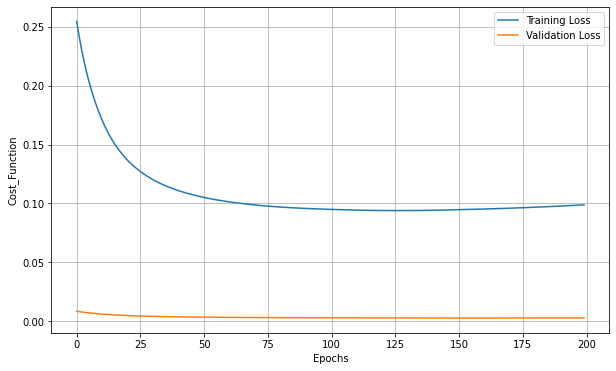

In [332]:
epochs=  200
if len(cost_func_graph) == 0:
  print("The data has not been trained yet")
else:
  plt.figure(figsize=(10,6))
  plt.plot([i for i in range(epochs)],cost_func_graph)
  plt.plot([i for i in range(epochs)],validation_cost_func_graph)
  plt.xlabel("Epochs")
  plt.ylabel("Cost_Function")
  plt.legend(['Training Loss', 'Validation Loss'])
  plt.grid(True)


### Testing the model using the test set

In [333]:
test_count = 0
for batch_index in range(len(batched_testing_data)):
  batch = batched_testing_features[batch_index]
  label = batched_testing_labels[batch_index]

  first_layer_output, first_layer_logits = feedforward(batch, weights[0], bias[0], 'relu')
  final_output, final_logits = feedforward(first_layer_output, weights[1], bias[1], 'softmax')

  one_hot_output= np.zeros_like(final_output)
  one_hot_output[np.arange(len(final_output)), final_output.argmax(1)] = 1

  count_for_batch = 0
  for i in range(len(label)):
    if (label[i] == one_hot_output[i]).all():
      count_for_batch += 1
  
  test_count += count_for_batch

train_count = 0
for batch_index in range(len(batched_training_data)):
  batch = batched_features[batch_index]
  label = batched_labels[batch_index]

  first_layer_output, first_layer_logits = feedforward(batch, weights[0], bias[0], 'relu')
  final_output, final_logits = feedforward(first_layer_output, weights[1], bias[1], 'softmax')

  one_hot_output= np.zeros_like(final_output)
  one_hot_output[np.arange(len(final_output)), final_output.argmax(1)] = 1

  count_for_batch = 0
  for i in range(len(label)):
    if (label[i] == one_hot_output[i]).all():
      count_for_batch += 1
  
  train_count += count_for_batch

print(f"Training Accuracy : {(train_count/10000)*100}")
print(f"Test Accuracy : {(test_count/4000)*100}")

Training Accuracy : 77.85
Test Accuracy : 75.85


### Taking a sample image and passing it through the model

In [334]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/NeuralNetworksFromScratch/Image files/trainingSample/img_602.jpg', cv2.IMREAD_GRAYSCALE)

In [335]:

from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [336]:
flattened_image = np.array([image.reshape(-1)])/255

test_first_layer_output, test_first_layer_logit = feedforward(flattened_image, weights[0], bias[0][0], 'relu')
test_output, test_logit = feedforward(test_first_layer_output, weights[1], bias[1][0], 'softmax')

one_hot_test_output= np.zeros_like(test_output)
one_hot_test_output[np.arange(len(test_output)), test_output.argmax(1)] = 1

print(one_hot_test_output)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
